<a href="https://colab.research.google.com/github/AnkitaDasData/AnalyticsHub/blob/main/Projects/Categorize_Countries_needs/Categorize_Countries_needs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Read and understand the data

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [131]:
import warnings
warnings.filterwarnings('ignore')

# loading data
import os
from google.colab import drive

# Define the mount point and your directory path
mount_path = '/content/drive/MyDrive/AnalyticsHub/Projects/Categorize_Countries_needs'

# Unmount the drive first to avoid issues
if os.path.exists('/content/drive'):
    try:
        drive.flush_and_unmount()
        print("Successfully unmounted the drive.")
    except:
        print("Drive not mounted, skipping unmount step.")

# Now, remove any existing files from the mount point if needed
if os.path.exists('/content/drive'):
    try:
        os.system('rm -rf /content/drive')
        print("Cleared the existing mount point.")
    except Exception as e:
        print(f"Error clearing mount point: {e}")

# Remount Google Drive
try:
    drive.mount('/content/drive', force_remount=True)  # Mount the drive
    print("Google Drive mounted successfully.")

    # Create the target directory if it doesn't exist
    if not os.path.exists(mount_path):
        os.makedirs(mount_path)
        print(f"Created directory: {mount_path}")
except ValueError as e:
    print(f"Failed to mount Google Drive: {e}")

# Reading the dataset
country_df  = pd.read_csv("/content/drive/MyDrive/AnalyticsHub/Projects/Categorize_Countries_needs/Country-data.csv")

from google.colab import sheets ##
sheet = sheets.InteractiveSheet(df=country_df ) ##

Successfully unmounted the drive.
Mounted at /content/drive
Google Drive mounted successfully.
https://docs.google.com/spreadsheets/d/1iAX1-7d89Q7-gsAlZdSR46dKi-ZAZ065WEAIHboLs8w#gid=0


In [132]:
# basics of the df
country_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [133]:
# missing values
round(100*(country_df.isnull().sum())/len(country_df), 2)

,0
country,0.0
child_mort,0.0
exports,0.0
health,0.0
imports,0.0
income,0.0
inflation,0.0
life_expec,0.0
total_fer,0.0
gdpp,0.0


In [134]:
country_df.shape

(167, 10)

In [135]:
country_df.describe()
#original df description

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


## 1.1 Convert percentage values to number values

In [136]:
country_df['exports']=(country_df['exports']/100)*country_df['gdpp']
country_df['imports']=(country_df['imports']/100)*country_df['gdpp']
country_df['health']=(country_df['health']/100)*country_df['gdpp']
country_df['child_mort']=(country_df['child_mort']*1000)

country_df['inflation']=country_df['gdpp']-(country_df['gdpp']/(country_df['inflation']+1))


In [137]:
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90200.0,55.30,41.9174,248.297,1610,500.030651,56.2,5.82,553
1,Albania,16600.0,1145.20,267.8950,1987.740,9930,3345.009107,76.3,1.65,4090
2,Algeria,27300.0,1712.64,185.9820,1400.440,12900,4199.181287,76.5,2.89,4460
3,Angola,119000.0,2199.19,100.6050,1514.370,5900,3379.145299,60.1,6.16,3530
4,Antigua and Barbuda,10300.0,5551.00,735.6600,7185.800,19100,7200.000000,76.8,2.13,12200


In [138]:
country_df.shape

(167, 10)

## 1.2 EDA of the data

In [139]:
country_df.describe()
#description post handling % values

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,1.670000e+02,167.000000,167.000000,167.000000
mean,38270.059880,7420.618847,1056.733204,6588.352108,17144.688623,-1.810609e+03,70.555689,2.947964,12964.155689
std,40328.931459,17973.885795,1801.408906,14710.810418,19278.067698,1.391191e+05,8.893172,1.513848,18328.704809
min,2600.000000,1.076920,12.821200,0.651092,609.000000,-1.776600e+06,32.100000,1.150000,231.000000
25%,8250.000000,447.140000,78.535500,640.215000,3355.000000,1.069871e+03,65.300000,1.795000,1330.000000
50%,19300.000000,1777.440000,321.886000,2045.580000,9960.000000,3.345009e+03,73.100000,2.410000,4660.000000
75%,62100.000000,7278.000000,976.940000,7719.600000,22800.000000,9.317851e+03,76.800000,3.880000,14050.000000
max,208000.000000,183750.000000,8663.600000,149100.000000,125000.000000,9.394444e+04,82.800000,7.490000,105000.000000


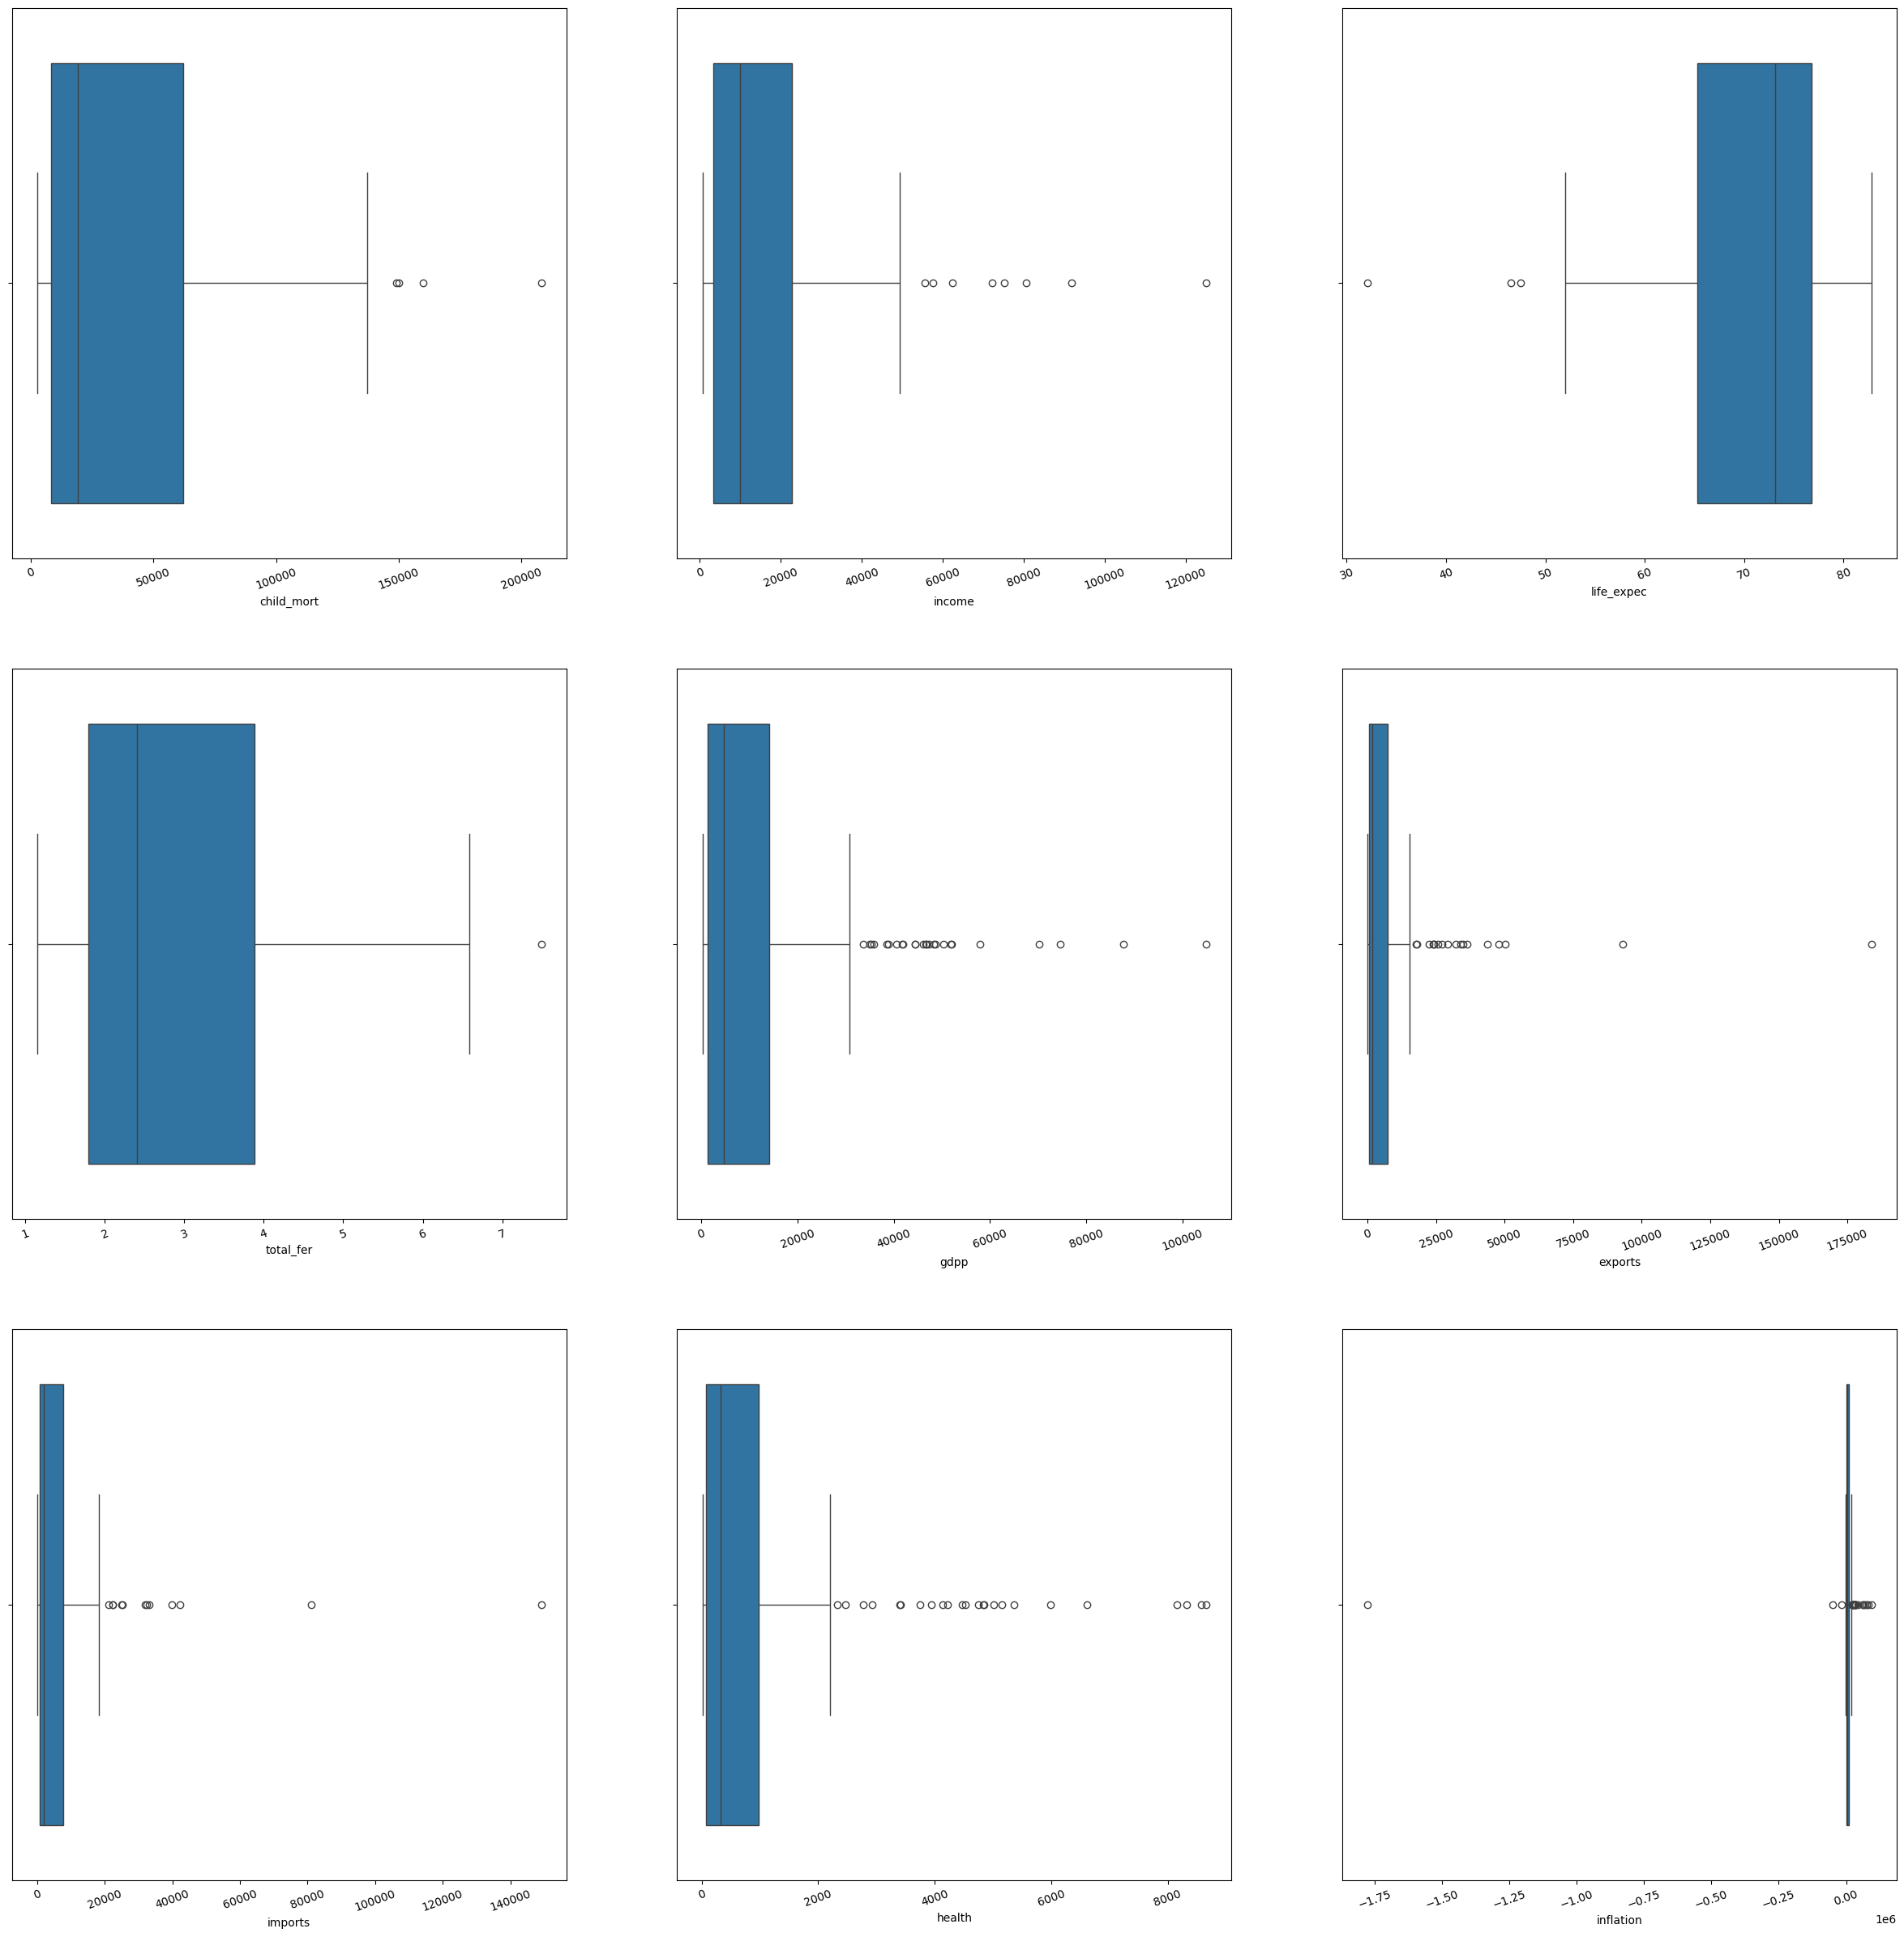

In [140]:
plt.figure(figsize=(30,30))
features = ['child_mort', 'income', 'life_expec', 'total_fer', 'gdpp',
       'exports', 'imports', 'health', 'inflation']
for i in enumerate(features):
    ax = plt.subplot(3, 3, i[0]+1)
    sns.boxplot(x=i[1], data=country_df)
    plt.xticks(rotation = 20)

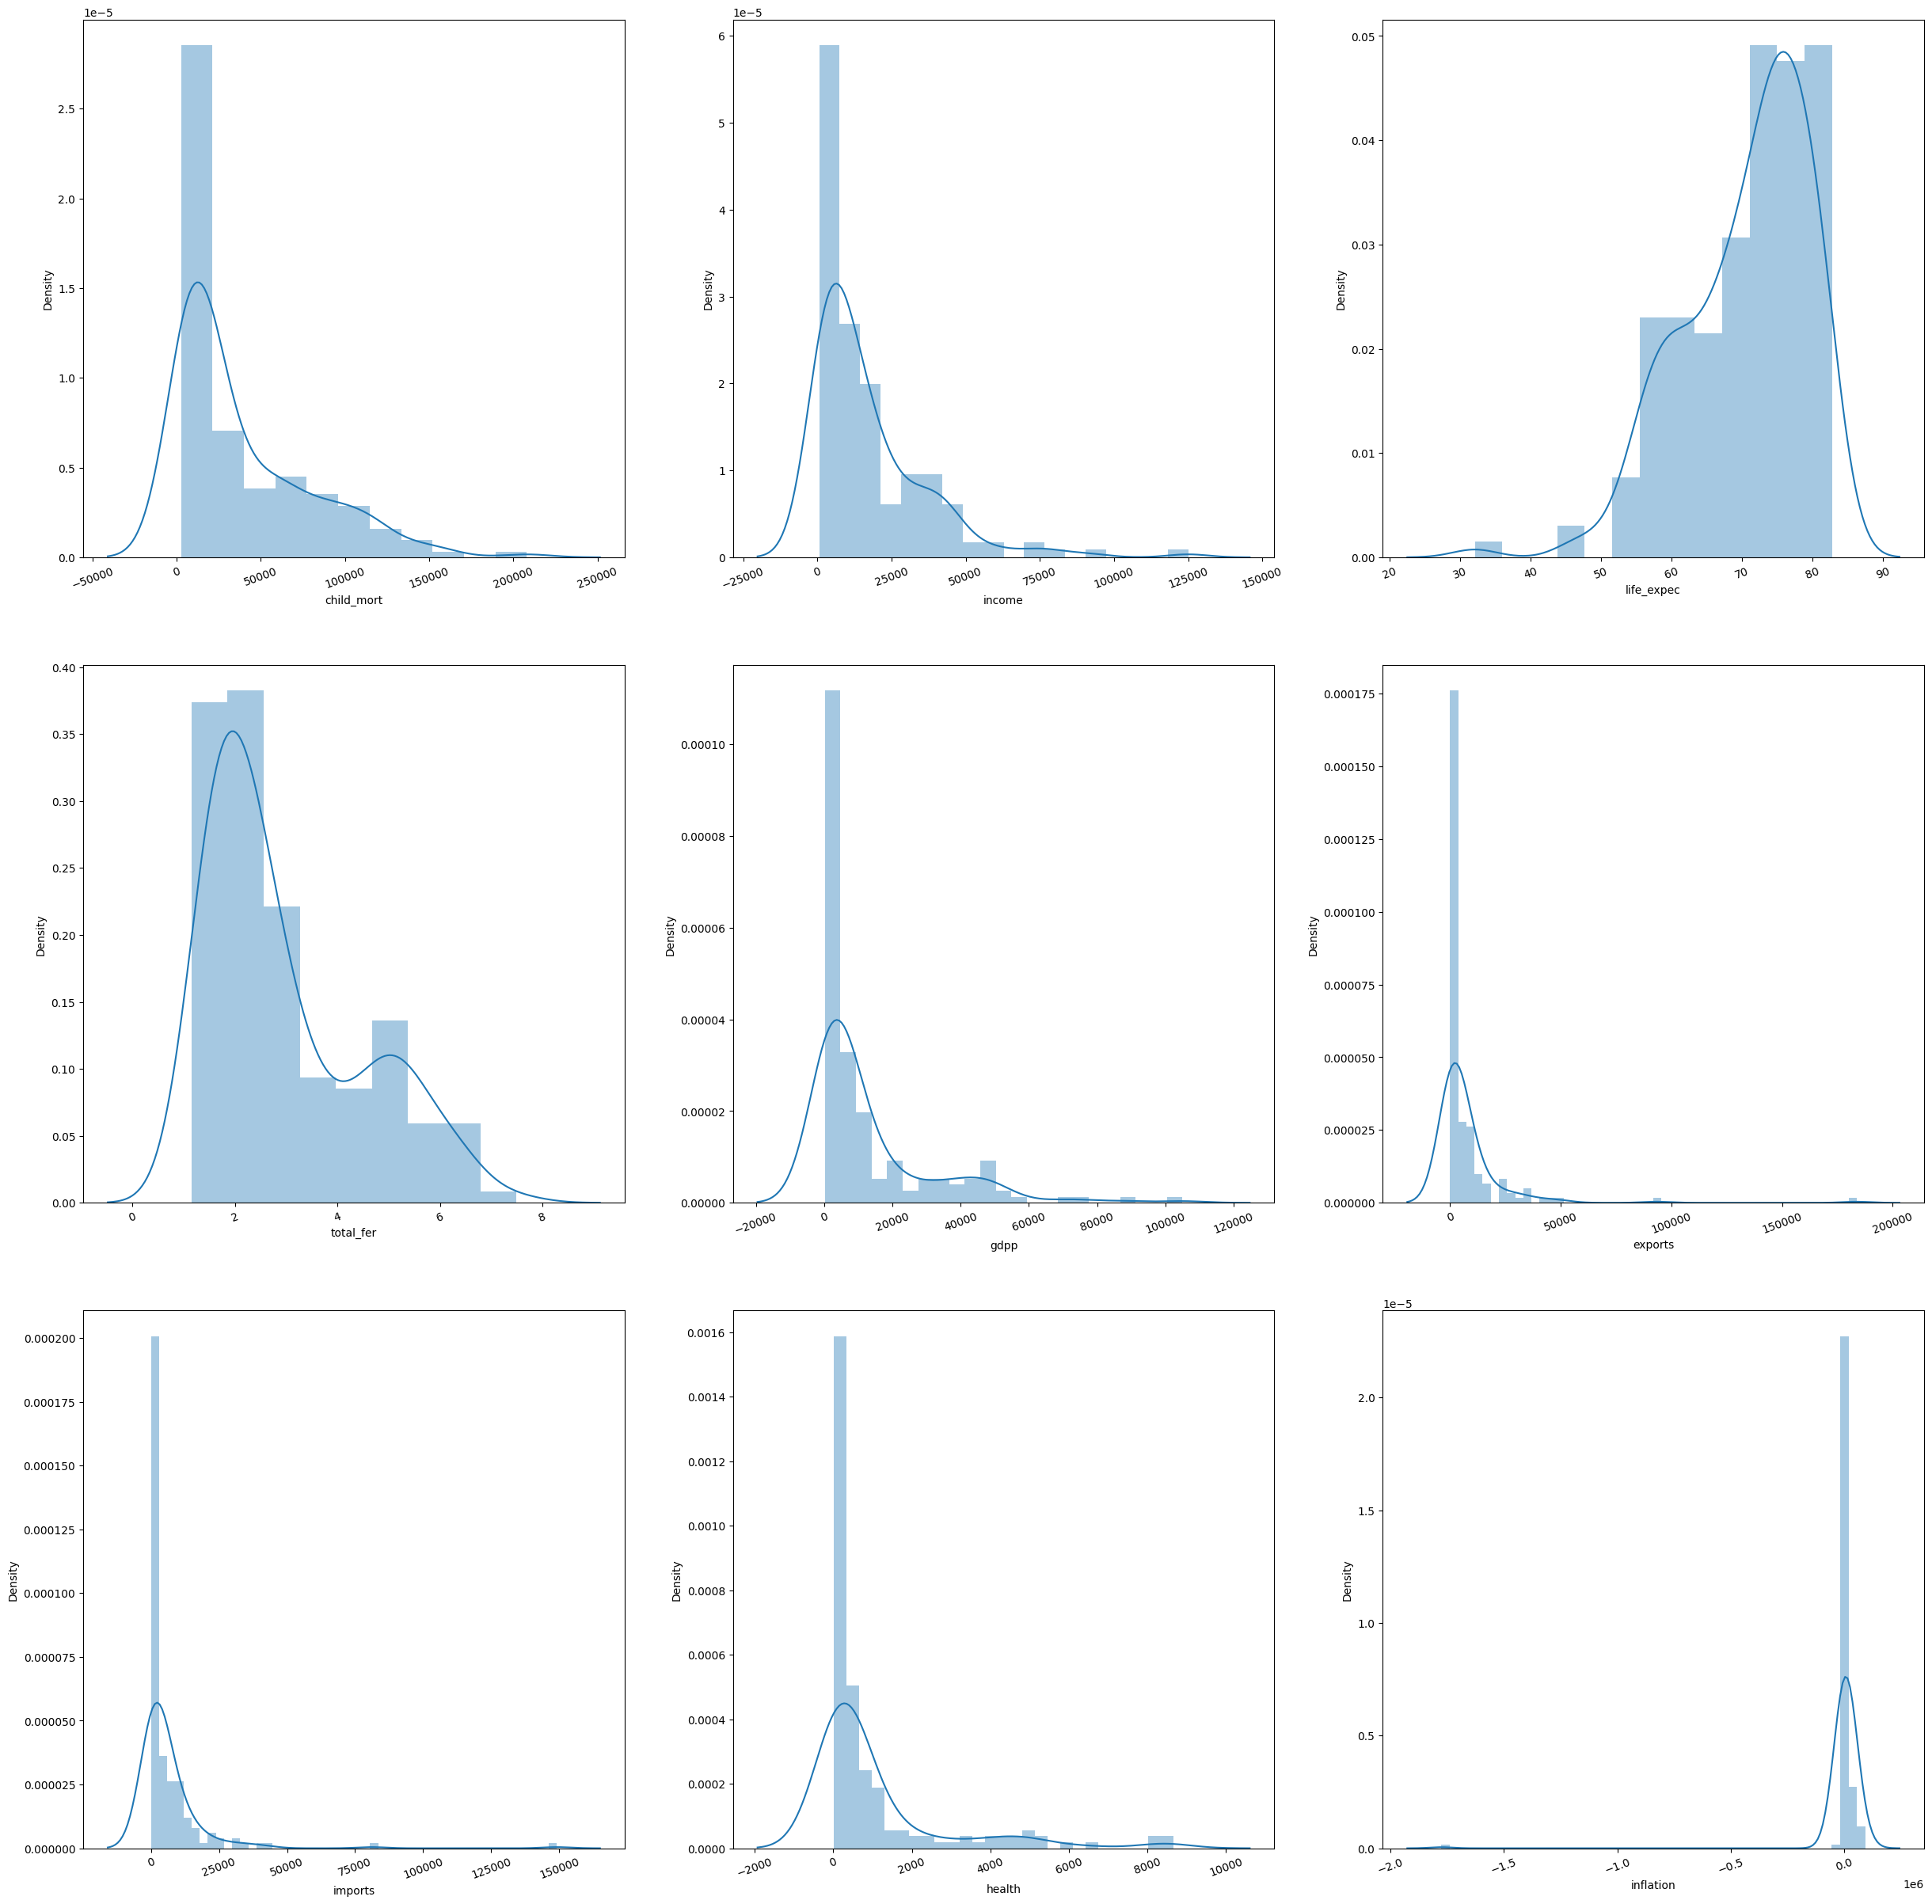

In [141]:
plt.figure(figsize=(30,30))
features = ['child_mort', 'income', 'life_expec', 'total_fer', 'gdpp',
       'exports', 'imports', 'health', 'inflation']
for i in enumerate(features):
    ax = plt.subplot(3, 3, i[0]+1)
    sns.distplot(country_df[i[1]])
    plt.xticks(rotation = 20)

In [142]:
country_df.columns

Index(['country', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp'],
      dtype='object')

In [143]:
#backup of original data after initial analysis and treatment
country_df_original=country_df

In [144]:
country_df_original.shape

(167, 10)

# 2. Preparation of data

## 2.1 Outlier Treatment

In [145]:
country_df.shape

(167, 10)

### handling outliers beyond  0.99 quantile

In [146]:
# handling outliers in gdpp
Q1 = country_df['gdpp'].quantile(0.01)
Q4 = country_df['gdpp'].quantile(0.99)
country_df['gdpp'][country_df['gdpp'] <= Q1]=Q1
country_df['gdpp'][country_df['gdpp'] >= Q4]=Q4
country_df.shape

(167, 10)

In [147]:
# handling outliers in child_mort
Q1 = country_df['child_mort'].quantile(0.01)
Q4 = country_df['child_mort'].quantile(0.99)
country_df['child_mort'][country_df['child_mort'] <= Q1]=Q1
country_df['child_mort'][country_df['child_mort'] >= Q4]=Q4
country_df.shape

(167, 10)

In [148]:
# handling outliers in income
Q1 = country_df['income'].quantile(0.01)
Q4 = country_df['income'].quantile(0.99)
country_df['income'][country_df['income'] <= Q1]=Q1
country_df['income'][country_df['income'] >= Q4]=Q4
country_df.shape

(167, 10)

In [149]:
# handling outliers in life_expec
Q1 = country_df['life_expec'].quantile(0.01)
Q4 = country_df['life_expec'].quantile(0.99)
country_df['life_expec'][country_df['life_expec'] <= Q1]=Q1
country_df['life_expec'][country_df['life_expec'] >= Q4]=Q4
country_df.shape

(167, 10)

In [150]:
# handling outliers in total_fer
Q1 = country_df['total_fer'].quantile(0.01)
Q4 = country_df['total_fer'].quantile(0.99)
country_df['total_fer'][country_df['total_fer'] <= Q1]=Q1
country_df['total_fer'][country_df['total_fer'] >= Q4]=Q4
country_df.shape

(167, 10)

In [151]:
# handling outliers in exports
Q1 = country_df['exports'].quantile(0.01)
Q4 = country_df['exports'].quantile(0.99)
country_df['exports'][country_df['exports'] <= Q1]=Q1
country_df['exports'][country_df['exports'] >= Q4]=Q4
country_df.shape

(167, 10)

In [152]:
# handling outliers in imports
Q1 = country_df['imports'].quantile(0.01)
Q4 = country_df['imports'].quantile(0.99)
country_df['imports'][country_df['imports'] <= Q1]=Q1
country_df['imports'][country_df['imports'] >= Q4]=Q4
country_df.shape

(167, 10)

In [153]:
# handling outliers in inflation
Q1 = country_df['inflation'].quantile(0.01)
Q4 = country_df['inflation'].quantile(0.99)
country_df['inflation'][country_df['inflation'] <= Q1]=Q1
country_df['inflation'][country_df['inflation'] >= Q4]=Q4
country_df.shape

(167, 10)

In [154]:
# handling outliers in health
Q1 = country_df['health'].quantile(0.01)
Q4 = country_df['health'].quantile(0.99)
country_df['health'][country_df['health'] <= Q1]=Q1
country_df['health'][country_df['health'] >= Q4]=Q4
country_df.shape

(167, 10)

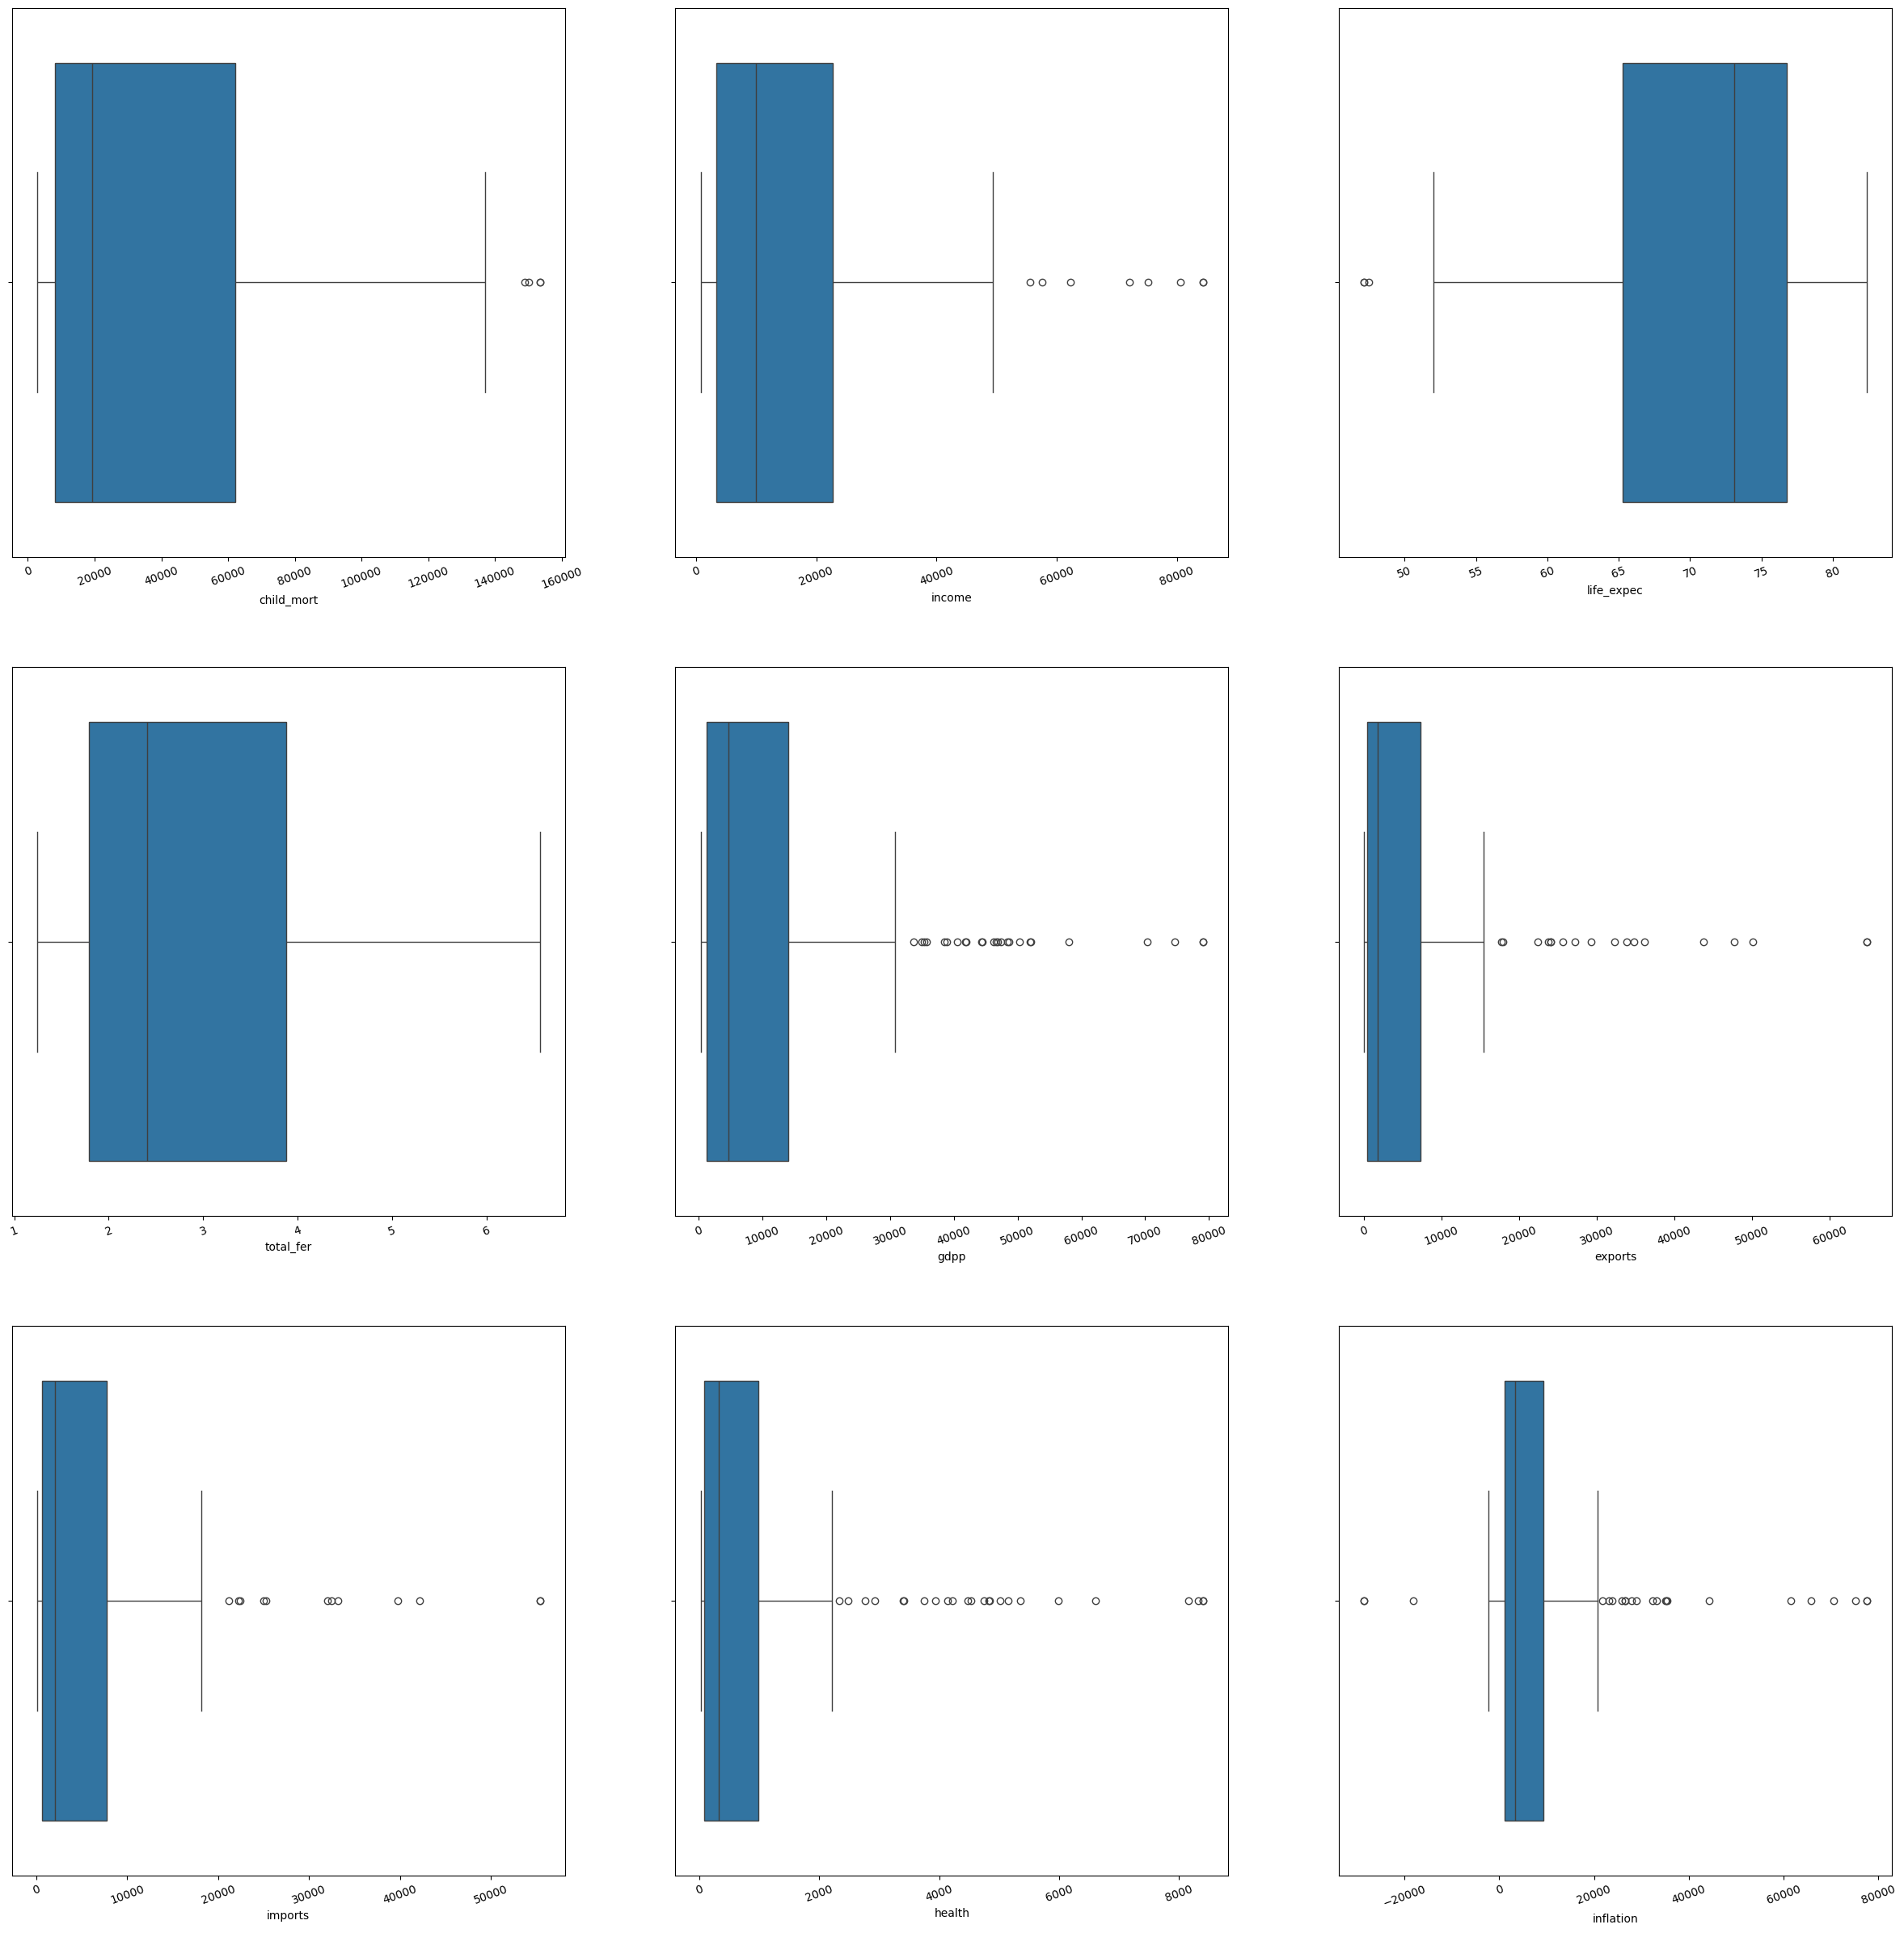

In [155]:
plt.figure(figsize=(30,30))
features = ['child_mort', 'income', 'life_expec', 'total_fer', 'gdpp',
       'exports', 'imports', 'health', 'inflation']
for i in enumerate(features):
    ax = plt.subplot(3, 3, i[0]+1)
    sns.boxplot(x=i[1], data=country_df)
    plt.xticks(rotation = 20)

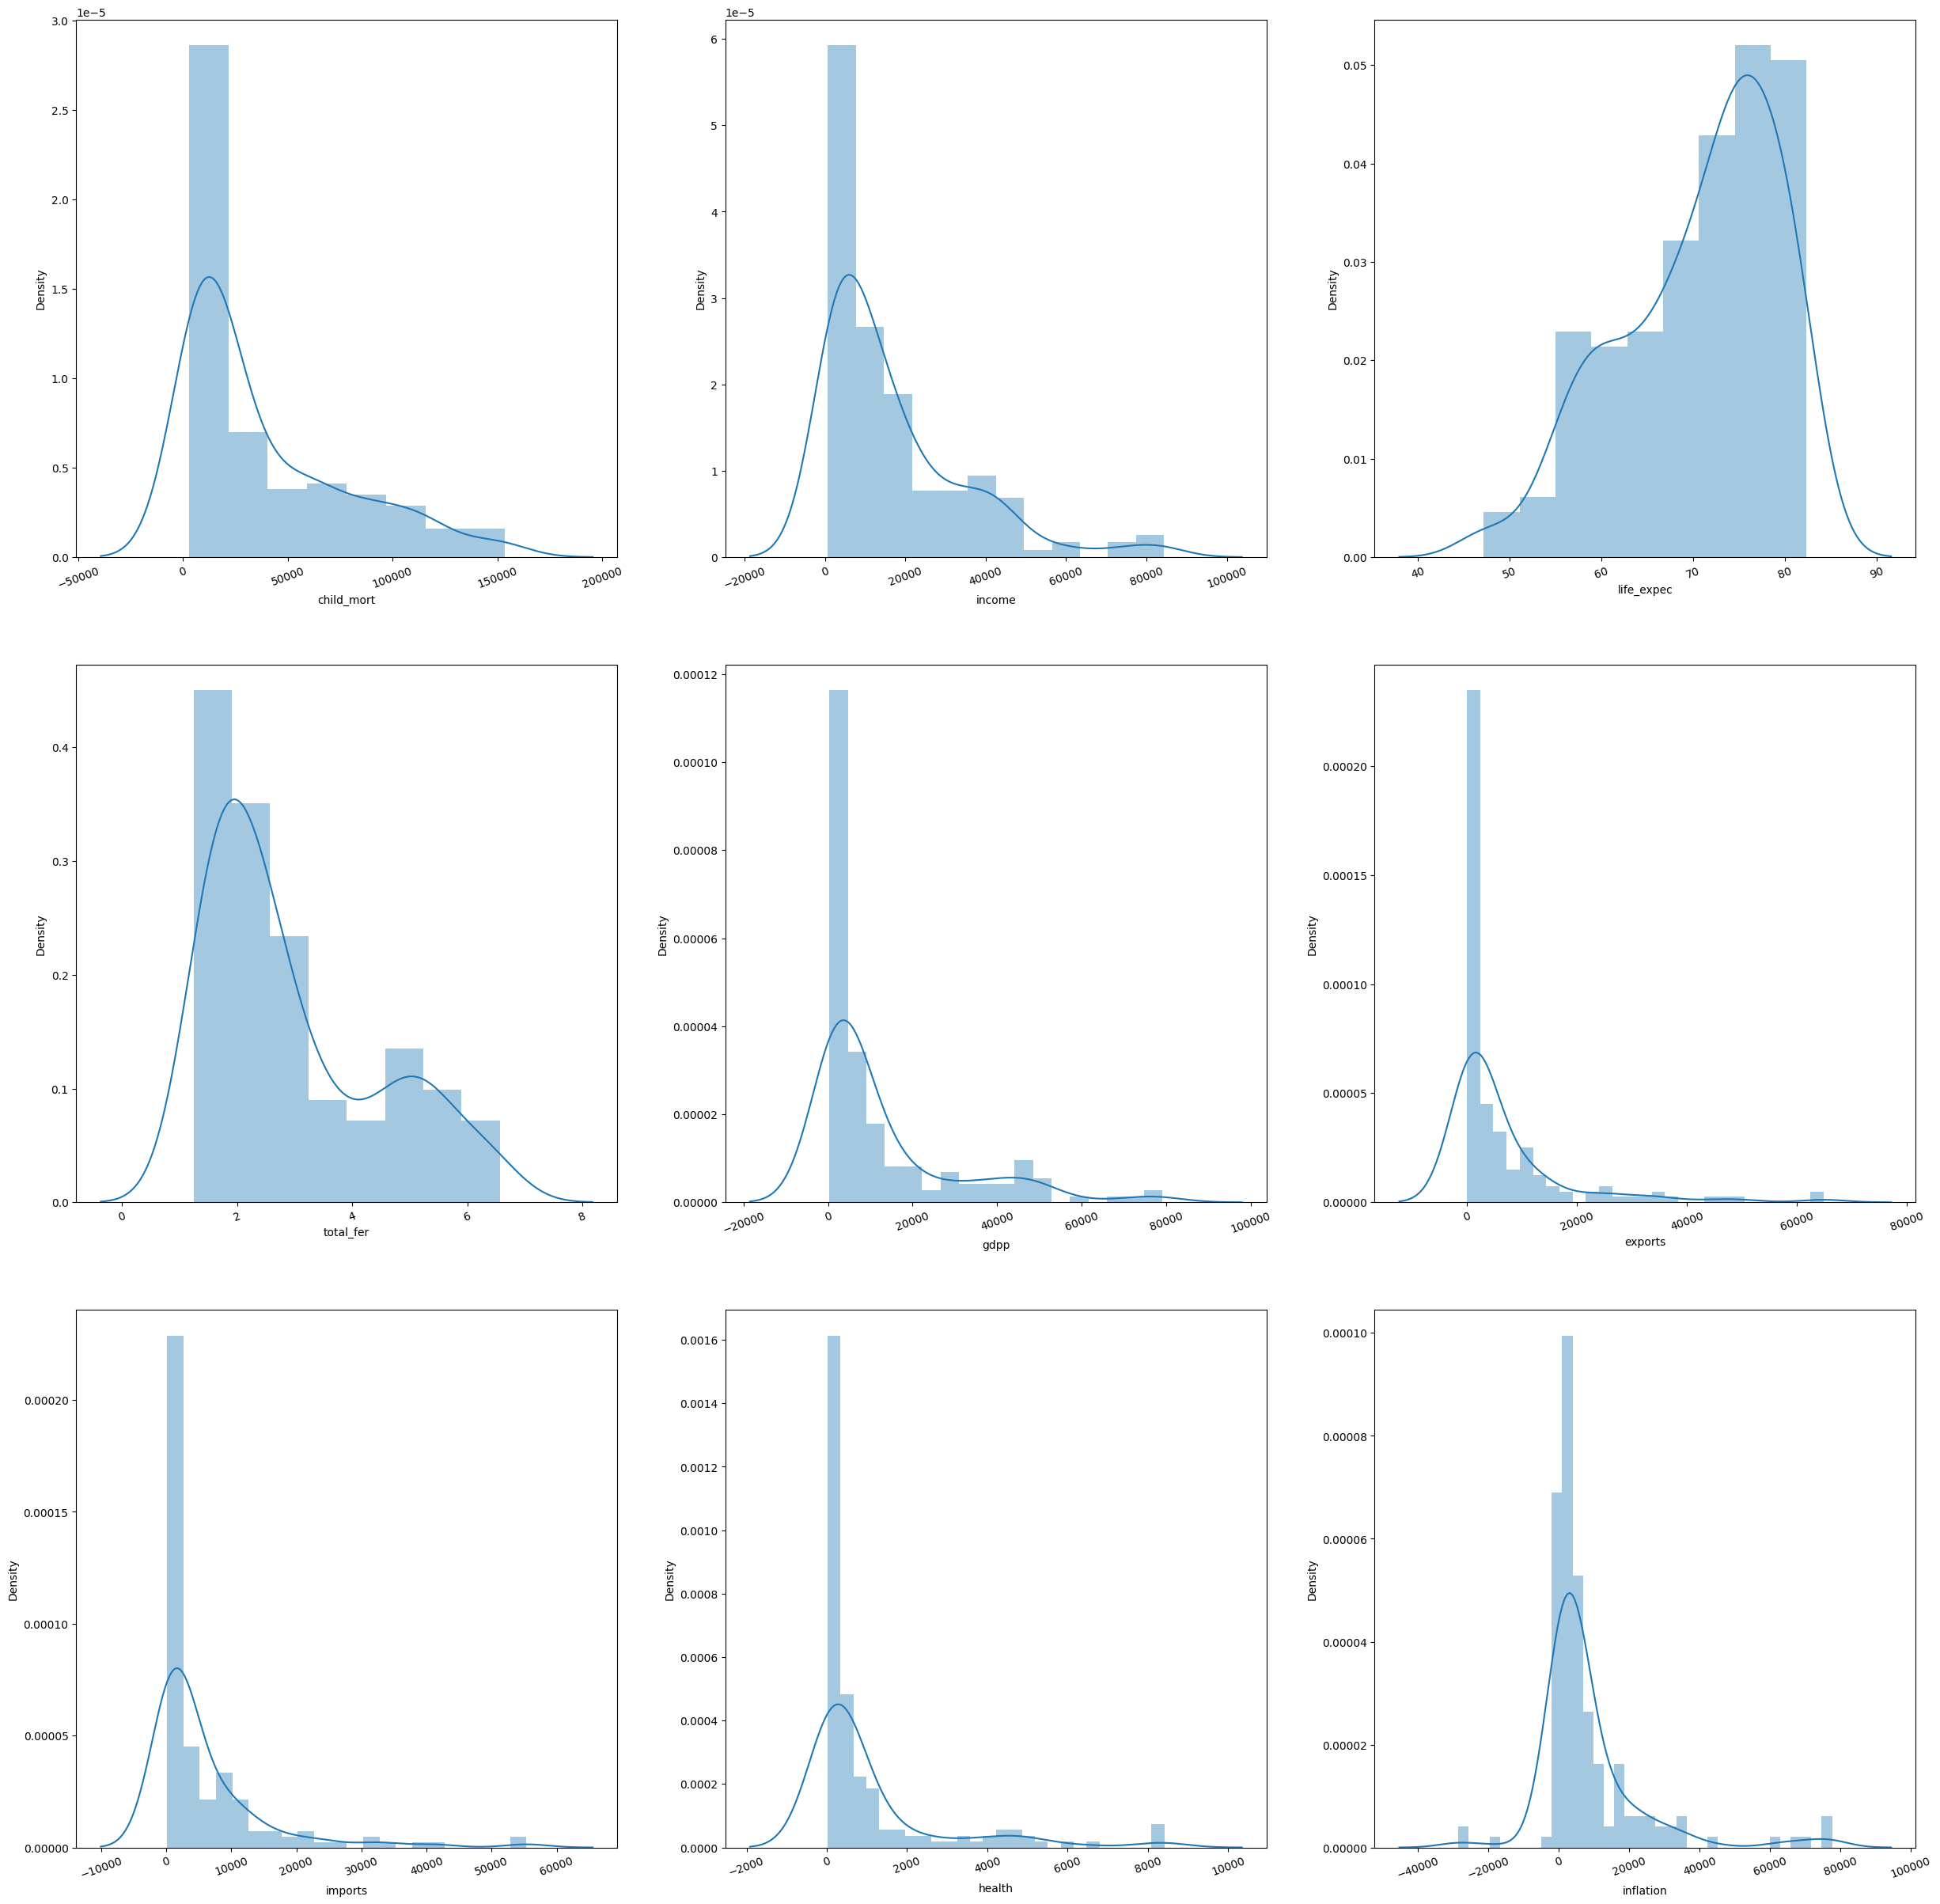

In [156]:
#gdpp, child_mort and income
plt.figure(figsize=(30,30))
features = ['child_mort', 'income', 'life_expec', 'total_fer', 'gdpp',
       'exports', 'imports', 'health', 'inflation']
for i in enumerate(features):
    ax = plt.subplot(3, 3, i[0]+1)
    sns.distplot(country_df[i[1]])
    plt.xticks(rotation = 20)

## 2.2 Hopkin's Test

In [157]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan

def hopkins(X):
    d = X.shape[1]
    n = len(X) # rows
    m = int(0.1 * n) # heuristic from article [1]
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)

    rand_X = sample(range(0, n, 1), m)

    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])

    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print (ujd, wjd)
        H = 0

    return H

In [158]:
round(hopkins(country_df.drop('country',axis=1)),2)

0.93

## 2.3 Scaling

In [159]:
## Let's make a copy of our original data before using it for analysis
country_df_original2 = country_df.copy()

In [160]:
country_df_original2.shape

(167, 10)

In [161]:
country_df_original2.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90200.0,55.30,41.9174,248.297,1610.0,500.030651,56.2,5.82,553.0
1,Albania,16600.0,1145.20,267.8950,1987.740,9930.0,3345.009107,76.3,1.65,4090.0
2,Algeria,27300.0,1712.64,185.9820,1400.440,12900.0,4199.181287,76.5,2.89,4460.0
3,Angola,119000.0,2199.19,100.6050,1514.370,5900.0,3379.145299,60.1,6.16,3530.0
4,Antigua and Barbuda,10300.0,5551.00,735.6600,7185.800,19100.0,7200.000000,76.8,2.13,12200.0


In [162]:
# Now for scaling numerical values
df1 = country_df.drop('country', axis = 1)

In [163]:
df1.shape

(167, 9)

In [164]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
df1 = standard_scaler.fit_transform(df1)

In [165]:
scaled_df=standard_scaler.fit_transform(df1)

In [166]:
df1 = pd.DataFrame(df1)
df1.columns = ['child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp']
df1.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.344012,-0.569638,-0.566983,-0.598844,-0.851772,-0.525308,-1.693799,1.926928,-0.702314
1,-0.547543,-0.473873,-0.440417,-0.413679,-0.387025,-0.341976,0.663053,-0.865911,-0.498775
2,-0.272548,-0.424015,-0.486295,-0.476198,-0.221124,-0.286933,0.686504,-0.035427,-0.477483
3,2.084186,-0.381264,-0.534113,-0.464070,-0.612136,-0.339777,-1.236499,2.154642,-0.531000
4,-0.709457,-0.086754,-0.178431,0.139659,0.125202,-0.093560,0.721681,-0.544433,-0.032079


# 3. Clustering - K Means

## 3.1 Choose K

### 3.1.2 Silhoutte Score results

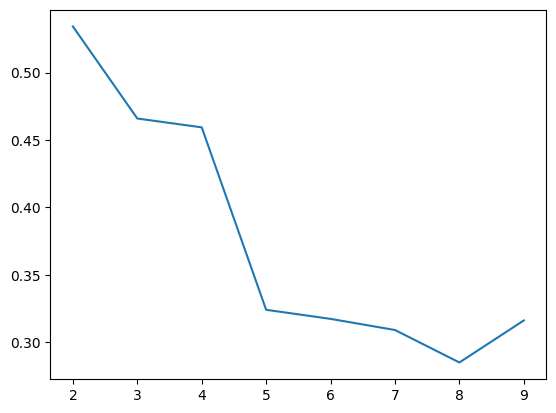

In [167]:
from sklearn.metrics import silhouette_score
ss = []
for k in range(2,10):
    kmeans = KMeans(n_clusters = k).fit(df1)
    ss.append([k, silhouette_score(df1, kmeans.labels_)])

plt.plot(pd.DataFrame(ss)[0], pd.DataFrame(ss)[1]);

In [168]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5,6]

for num_clusters in range_n_clusters:

    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(df1)

    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg = silhouette_score(df1, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))



For n_clusters=2, the silhouette score is 0.5301529121191914
For n_clusters=3, the silhouette score is 0.4659675623522211
For n_clusters=4, the silhouette score is 0.4594091224777195
For n_clusters=5, the silhouette score is 0.4359805559888735
For n_clusters=6, the silhouette score is 0.34832623740734603


### 3.1.2 Elbow Curve Results

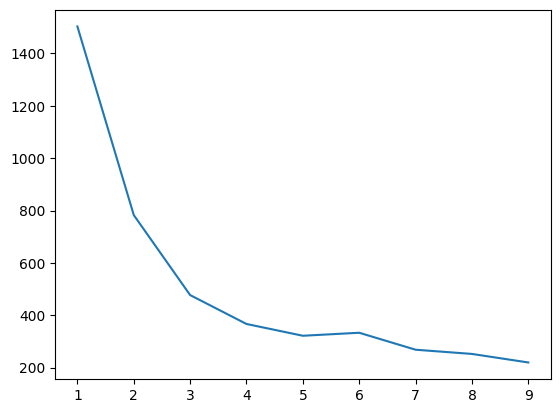

In [169]:
ssd = []
for k in list(range(1,10)):
    model = KMeans(n_clusters = k, max_iter = 50).fit(df1)
    ssd.append([k, model.inertia_])

plt.plot(pd.DataFrame(ssd)[0], pd.DataFrame(ssd)[1]);

## 3.2 Run K Means with K chosen

In [170]:
# final model with k=3 selected
kmeans = KMeans(n_clusters=3, max_iter=500)
kmeans.fit(df1)

KMeans(max_iter=500, n_clusters=3)

In [171]:
# assign the label
country_df['cluster_id'] = kmeans.labels_
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,Afghanistan,90200.0,55.30,41.9174,248.297,1610.0,500.030651,56.2,5.82,553.0,1
1,Albania,16600.0,1145.20,267.8950,1987.740,9930.0,3345.009107,76.3,1.65,4090.0,2
2,Algeria,27300.0,1712.64,185.9820,1400.440,12900.0,4199.181287,76.5,2.89,4460.0,2
3,Angola,119000.0,2199.19,100.6050,1514.370,5900.0,3379.145299,60.1,6.16,3530.0,1
4,Antigua and Barbuda,10300.0,5551.00,735.6600,7185.800,19100.0,7200.000000,76.8,2.13,12200.0,2


In [172]:
# Check the count of observation per cluster
country_df['cluster_id'].value_counts()

,count
cluster_id,
2,92
1,47
0,28


## 3.3 Vizualize Clusters

<Axes: xlabel='child_mort', ylabel='income'>

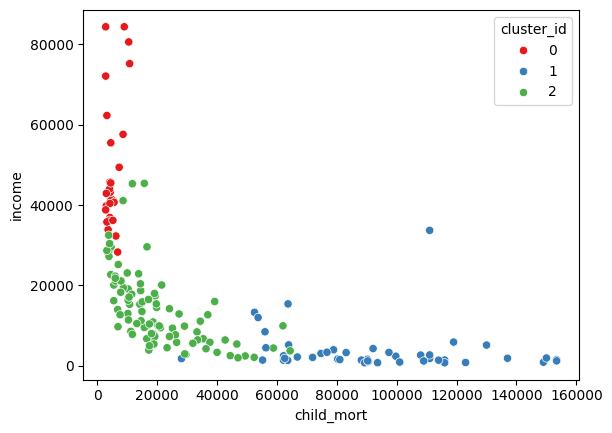

In [173]:
# Plot the Cluster with respect to the clusters obtained
sns.scatterplot(x = 'child_mort', y = 'income', hue ='cluster_id', legend = 'full', data = country_df, palette='Set1')

<Axes: xlabel='child_mort', ylabel='gdpp'>

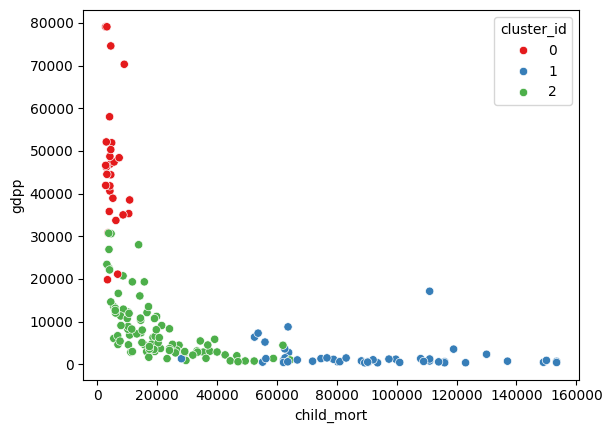

In [174]:
# Plot the Cluster with respect to the clusters obtained
sns.scatterplot(x = 'child_mort', y = 'gdpp', hue ='cluster_id', legend = 'full', data = country_df, palette='Set1')

## 3.4 Cluster Profiling results of K Means Clusters

In [175]:
country_df.drop('country', axis = 1).groupby('cluster_id').mean()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
cluster_id,,,,,,,,,
0,5039.285714,25962.454286,4263.217529,21703.292143,48316.000000,34333.916462,80.330000,1.769043,46488.428571
1,91472.340426,860.078458,109.332386,812.281673,3713.797447,1651.098972,59.404681,4.981004,1856.324255
2,20541.304348,3527.524623,560.319787,3641.986735,13999.891304,4412.107933,73.440217,2.258948,8060.565217


<Axes: xlabel='cluster_id'>

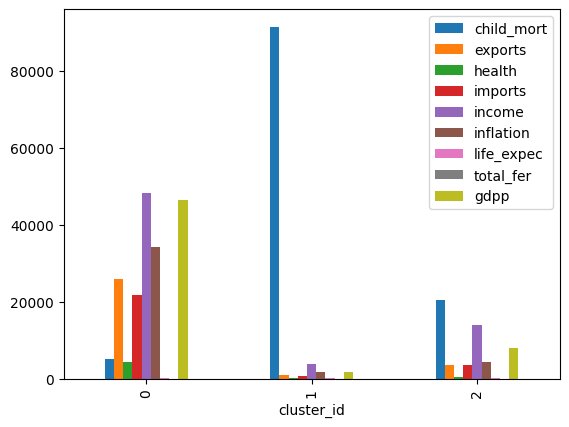

In [176]:
country_df.drop('country', axis = 1).groupby('cluster_id').mean().plot(kind = 'bar')

<Axes: xlabel='cluster_id'>

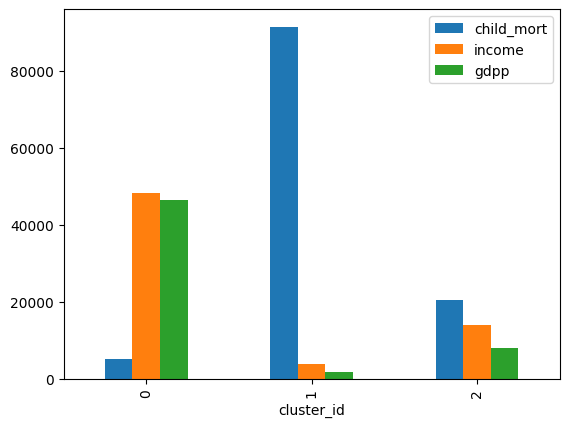

In [177]:
country_df.drop('country', axis = 1)[['child_mort', 'income', 'gdpp','cluster_id']].groupby('cluster_id').mean().plot(kind = 'bar')

### worst child_mort, income, gdpp observed in cluster 2

In [178]:
country_df[country_df.cluster_id.eq(2)].sort_values(['gdpp','child_mort', 'income',], ascending=[True, False,True]).head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
109,Nepal,47000.0,56.713600,31.0800,215.48800,1990.0,555.229814,68.3,2.61,592.0,2
146,Tajikistan,52400.0,109.962000,44.1324,432.46800,2110.0,683.333333,69.6,3.51,738.0,2
12,Bangladesh,49400.0,121.280000,26.6816,165.24400,2440.0,664.879607,70.4,2.33,758.0,2
27,Cambodia,44400.0,425.226000,44.6448,467.67000,2520.0,595.223301,66.1,2.88,786.0,2
83,Kyrgyz Republic,29600.0,454.080000,54.3840,718.96000,2790.0,800.000000,68.5,3.10,880.0,2
107,Myanmar,64400.0,22.243716,19.4636,104.90964,3720.0,865.114428,66.8,2.41,988.0,2
164,Vietnam,23300.0,943.200000,89.6040,1050.62000,4490.0,1210.000000,73.1,1.95,1310.0,2
69,India,58800.0,305.100000,54.6750,365.85000,4410.0,1214.729459,66.2,2.60,1350.0,2
161,Uzbekistan,36300.0,437.460000,80.1780,393.30000,4240.0,1301.142857,68.8,2.34,1380.0,2
102,Moldova,17200.0,638.960000,190.7100,1279.55000,3910.0,1495.289256,69.7,1.27,1630.0,2


# 4. Hierarchical Clustering

## 4.1 Single and Complete Linkage Analysis

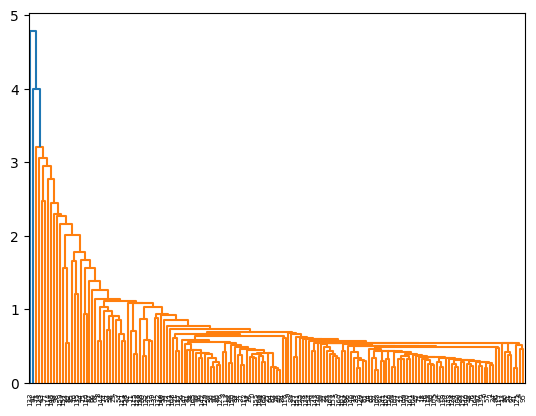

In [179]:
# single linkage
mergings = linkage(scaled_df, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

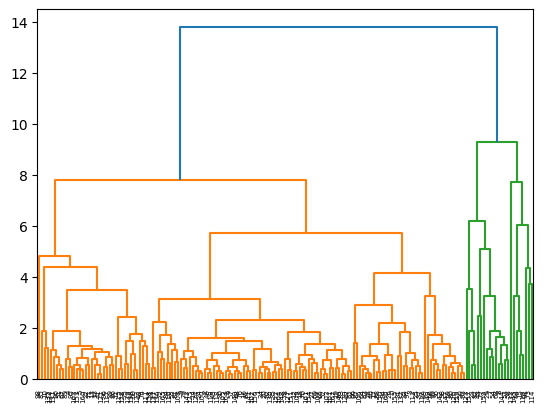

In [180]:
# complete linkage
mergings = linkage(scaled_df, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

## 4.2 Choose one of the methods based on results

#### Complete linkage is superior in terms of grouping

In [181]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [182]:
# assign cluster labels
country_df_original2['cluster_labels'] = cluster_labels
country_df_original2.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_labels
0,Afghanistan,90200.0,55.30,41.9174,248.297,1610.0,500.030651,56.2,5.82,553.0,0
1,Albania,16600.0,1145.20,267.8950,1987.740,9930.0,3345.009107,76.3,1.65,4090.0,0
2,Algeria,27300.0,1712.64,185.9820,1400.440,12900.0,4199.181287,76.5,2.89,4460.0,0
3,Angola,119000.0,2199.19,100.6050,1514.370,5900.0,3379.145299,60.1,6.16,3530.0,0
4,Antigua and Barbuda,10300.0,5551.00,735.6600,7185.800,19100.0,7200.000000,76.8,2.13,12200.0,0


In [183]:
# Check the count of observation per cluster
country_df_original2['cluster_labels'].value_counts()

,count
cluster_labels,
0,144
1,15
2,8


## 4.3 Vizualize the clusters

<Axes: xlabel='child_mort', ylabel='income'>

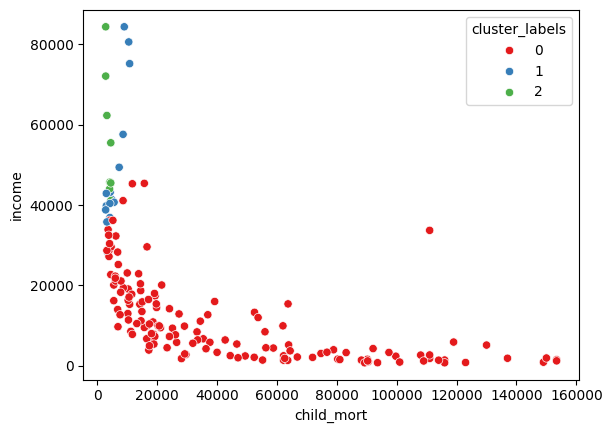

In [184]:
# Plot the Cluster with respect to the clusters obtained
sns.scatterplot(x = 'child_mort', y = 'income', hue ='cluster_labels', legend = 'full', data = country_df_original2, palette='Set1')

<Axes: xlabel='child_mort', ylabel='gdpp'>

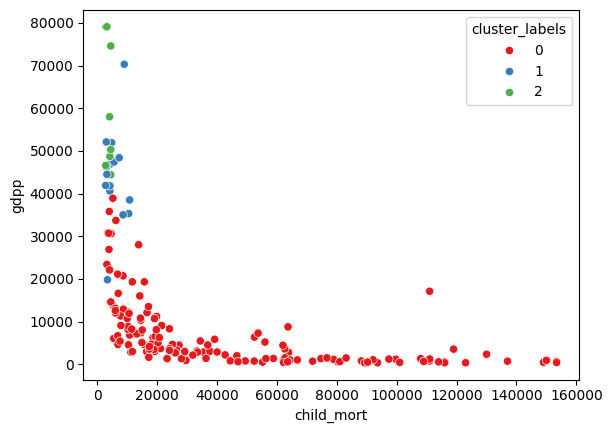

In [185]:
# Plot the Cluster with respect to the clusters obtained
sns.scatterplot(x = 'child_mort', y = 'gdpp', hue ='cluster_labels', legend = 'full', data = country_df_original2, palette='Set1')

## 4.4 Cluster profiling of the Hierarchical Clusters

In [186]:
country_df_original2.drop('country', axis = 1).groupby('cluster_labels').mean()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
cluster_labels,,,,,,,,,
0,43158.333333,3075.715645,492.481615,3156.936238,11315.545000,4026.470811,69.108472,3.126808,6868.883611
1,5646.666667,19148.260000,3771.941360,14548.980000,49024.933333,35309.128115,79.911333,1.819333,44040.000000
2,3825.000000,45222.215000,6070.207550,38512.335000,56321.750000,41927.065494,80.933750,1.739150,60097.000000


<Axes: xlabel='cluster_labels'>

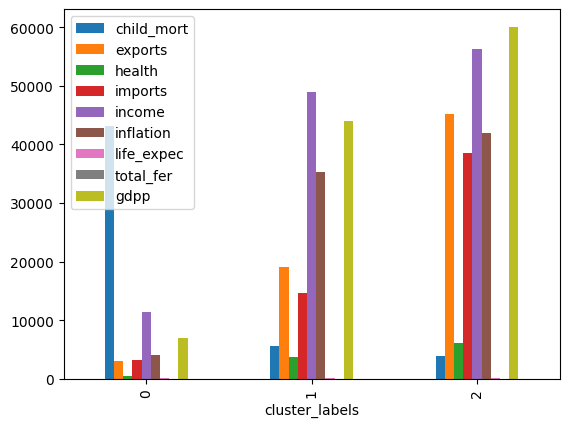

In [187]:
country_df_original2.drop('country', axis = 1).groupby('cluster_labels').mean().plot(kind = 'bar')

<Axes: xlabel='cluster_labels'>

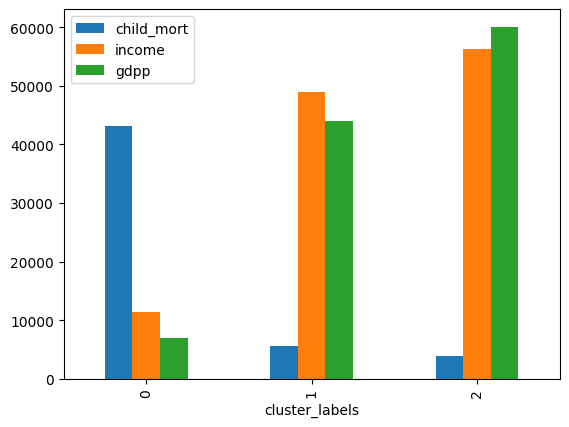

In [188]:
country_df_original2.drop('country', axis = 1)[['child_mort', 'income', 'gdpp','cluster_labels']].groupby('cluster_labels').mean().plot(kind = 'bar')

### worst child_mort, income, gdpp observed in cluster 0

In [189]:
country_df_original2[country_df_original2.cluster_labels.eq(0)].sort_values(['gdpp','child_mort', 'income',], ascending=[True, False,True]).head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_labels
26,Burundi,93600.0,22.243716,26.796000,104.90964,764.00,213.631579,57.7,6.2600,331.62,0
88,Liberia,89300.0,62.457000,38.586000,302.80200,742.24,276.459042,60.8,5.0200,331.62,0
37,"Congo, Dem. Rep.",116000.0,137.274000,26.419400,165.66400,742.24,318.678899,57.5,6.5400,334.00,0
112,Niger,123000.0,77.256000,17.956800,170.86800,814.00,249.971831,58.8,6.5636,348.00,0
132,Sierra Leone,153400.0,67.032000,52.269000,137.65500,1220.00,377.076923,55.0,5.2000,399.00,0
93,Madagascar,62200.0,103.250000,17.009362,177.59000,1390.00,370.814096,60.8,4.6000,413.00,0
106,Mozambique,101000.0,131.985000,21.829900,193.57800,918.00,370.504630,54.5,5.5600,419.00,0
31,Central African Republic,149000.0,52.628000,17.750800,118.19000,888.00,297.827243,47.5,5.2100,446.00,0
94,Malawi,90500.0,104.652000,30.248100,160.19100,1030.00,423.961832,53.1,5.3100,459.00,0
50,Eritrea,55200.0,23.087800,17.009362,112.30600,1420.00,443.746032,61.7,4.6100,482.00,0


# 5. Country Identification

### Top 5 countries by low gdpp , low income and high child mort are found to be the same from both the Clustering processes

## 5.1 Sort and Filter countries as per requirement

In [190]:
#From K means clustering
country_df[country_df.cluster_id.eq(2)].sort_values(['gdpp','child_mort', 'income',], ascending=[True, False,True]).head(5)['country']

,country
109,Nepal
146,Tajikistan
12,Bangladesh
27,Cambodia
83,Kyrgyz Republic


In [191]:
#From Hierarchical Clustering
country_df_original2[country_df_original2.cluster_labels.eq(0)].sort_values(['gdpp','child_mort', 'income',], ascending=[True, False,True]).head(5)['country']

,country
26,Burundi
88,Liberia
37,"Congo, Dem. Rep."
112,Niger
132,Sierra Leone


## 5.2 Select top 5 countries for recommendation

### Burundi, Liberia, Congo, Niger, Sierra Leone are the candidates for funding <br> Child mortality appears to be the highest in these countries and at the same time they fare poorly on financial measures such as income and gdpp as well